# ch05.12. 사이킷런 실습 - 검증과 하이퍼파라미터 튜닝


---
* 날짜: 2022.05.30
* 이름: 윤태우

## 학습내용
    - 머신러닝 모델 성능 평가하기
    - 머신러닝 알고리즘에서 일반적으로 발생하는 문제 분석하기
    - 머신러닝 모델 세부 튜닝
    - 여러가지 성능 지표를 사용해 모델의 예측 성능 평가하기


## 학습자료
- [머신러닝 교과서 with파이썬, 사이킷런, 텐서플로](http://www.kyobobook.co.kr/product/detailViewKor.laf?mallGb=KOR&ejkGb=KOR&barcode=9791165215187)
- 6장. 모델 평가와 하이퍼파라미터 튜닝의 모범 사례

```
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 데이터 소개 : 위스콘신 유방암 데이터셋
---

* 악성과 양성인 종양 세포 샘플 569개
* 열1 : 샘플의 고유 ID
* 열2 : 진단 결과 {M: 악성, B: 양성}
* 열3 - 열 32 : 디지털 이미지에서 계산된 30개의 실수 값 특성



### | 데이터 준비

```
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
```

* 데이터 로드 및 헤드 확인

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
print(df.shape)
df.head()

(569, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


* y 클래스별 개수 시각화

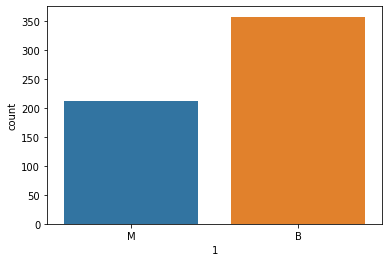

In [ ]:
sns.countplot(data = df, x=1)
plt.show()

### | 데이터 전처리

* 판다스에서 정수 인코딩 하기

In [ ]:
df[1].map({'B':0, 'M': 1})

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: 1, Length: 569, dtype: int64

* 사이킷런으로 정수 인코딩 하기

```
from sklearn.preprocessing import LabelEncoder
```


In [ ]:
from sklearn.preprocessing import LabelEncoder
# X,y 값 설정
X = df.loc[:, 2:].values
y = df.loc[:, 1].values   # 악성 or 양성 (M : 악성, B : 양성)
print(X.shape, y.shape)
print(X[:2], y[:2])

# 정수 인코딩
le = LabelEncoder()
y = le.fit_transform(y) # 학습과 변환 
print(X.shape, y.shape)
print(X[:2], y[:2])
print('인코딩된 클래스 순서:', le.classes_)

(569, 30) (569,)
[[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 1.326e+03 8.474e-02 7.864e-02 8.690e-02
  7.017e-02 1.812e-01 5.667e-02 5.435e-01 7.339e-01 3.398e+00 7.408e+01
  5.225e-03 1.308e-02 1.860e-02 1.340e-02 1.389e-02 3.532e-03 2.499e+01
  2.341e+01 1.588e+02 1.956e+03 1.238e-01 1.866e-01 2.416e-01 1.860e-01
  2.750e-01 8.902e-02]] ['M' 'M']
(569, 30) (569,)
[[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 

* 샘플에 인코딩 적용

In [ ]:
sample = ['M', 'B', 'B', 'M']
le.transform(sample)

array([1, 0, 0, 1])

* 데이터 분할

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y, # 분리시 y분포가 유사하도록
                                                    random_state=1 
                                                    )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

## 효과적인 모델 구상과 평가
---

### **| 모델 파이프라인 제작**

```
sklearn.pipeline.make_pipeline(*steps, 
                               memory=None, 
                               verbose=False)

```

* z-score 스케일링 -> 로지스틱 회귀

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import set_config

set_config(display='diagram')
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(random_state=1)
                        )
pipe_lr.fit(X_train, y_train)
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=1))])

* z-score 스케일링 -> SVC

In [ ]:
from sklearn.svm import SVC
set_config(display='diagram')
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1)
                        )
pipe_svc.fit(X_train, y_train)
pipe_svc

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=1))])

* z-score 스케일링 -> PCA -> SVC

In [ ]:
from sklearn.decomposition import PCA

set_config(display='diagram')
pipe_pca_svc = make_pipeline(StandardScaler(),
                             PCA(n_components=2, random_state=1),
                             SVC(random_state=1)
                             )
pipe_pca_svc.fit(X_train, y_train)
pipe_pca_svc

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2, random_state=1)),
                ('svc', SVC(random_state=1))])

### **| k-겹 교차 검증을 사용한 모델 성능 평가**

#### **홀드아웃(holdout cross-validation)**

<p align='center'>
<img src=https://git.io/JtsTo?raw=true width=600>
</p>

* 초기 데이터셋을 별도의 훈련 데이터셋과 테스트 데이터셋으로 분리
* 성능 향상을 위해 하이퍼파라미터를 튜닝하고 비교하는 과정을 모델 선택이라고 한다.
* 하이퍼파라미터 튜닝의 기준은 테스트셋이고 따라서 하이퍼파라미터를 튜닝하는 과정에서 테스트셋도 모델 선택의 일부가 되버린다.
* 홀드아웃 방법은 데이터를 훈련 데이터, 검증 데이터, 테스트 데이터셋 세가지로 나누는 것. 
* 훈련 데이터셋 : 학습 파라미터 조정
* 검증 데이터셋 : 하이퍼 파라미터 조정
* 테스트 데이터셋 : 최종 성능 평가

#### **k-겹 교차검증(k-fold cross-validation)**

<p align='center'>
<img src=https://git.io/JtsT6?raw=true width=600>
</p>


* 중복을 허용하지 않고 훈련 데이터셋을 k개의 폴드로 랜덤하게 나눈다.
* k-1개의 폴드로 모델 훈련을 k번 하여 k개의 모델 확보
* k개 모델에 대한 k번의 성능 평가 진행
* 일반적으로 최적의 하이퍼파라미터 값을 찾기 위해 사용
* 최적의 하이퍼파라미터를 찾은 후에는 전체 훈련 데이터셋을 사용해 모델을 재훈련
* 최종 성능 추정은 독립적인 테스트셋(이제껏 사용하지 않은 데이터)을 사용하여 추정.


```
sklearn.model_selection.cross_validate(estimator, 
                                       X, y=None, 
                                       groups=None,
                                       scoring=None, 
                                       cv=None, 
                                       n_jobs=None,
                                       verbose=0,
                                       fit_params=None,
                                       pre_dispatch='2*n_jobs', 
                                       return_train_score=False, 
                                       return_estimator=False, 
                                       error_score=nan)
```

In [ ]:
from sklearn.model_selection import cross_validate

df = pd.DataFrame()
for pipe in ['pipe_lr', 'pipe_svc', 'pipe_pca_svc']:
  scores = cross_validate(estimator = eval(pipe),
                          X = X_train, 
                          y = y_train,
                          scoring=['accuracy'],
                          cv = 10
                          )
  df[pipe] = scores['test_accuracy']
  mean_score = np.mean(scores['test_accuracy']).round(3)
  print(f'{pipe} 평균성능 : {mean_score}')

pipe_lr 평균성능 : 0.98
pipe_svc 평균성능 : 0.978
pipe_pca_svc 평균성능 : 0.932


## 머신러닝 성능향상을 위한 디버깅과 튜닝
---

### **| 알고리즘 디버깅**



#### **학습 곡선**

    - 주어진 훈련 데이터셋에 비해 모델이 너무 복잡하면 모델이 과대적합되고 처음 본 데이터에 잘 일반화 되지 못하는 경향이 생긴다.
    - 이를 해결하는 가장 효과적인 방법은 훈련 샘플을 더 모으기
    - 하지만 데이터를 모으는 비용과 시간이 소요되기 때문에 훈련 정확도와 검증 정확도를 훈련 데이터 셋 크기 함수로 그래프를 그린다.



<p align='center'>
<img src=https://git.io/JtsTi?=true width=600>
</p>


    과소 적합 
      - 훈련 정확도와 테스트 정확도가 모두 낮다
      - 일반적으로 모델이 훈련 데이터에 대해서도 학습을 못한 상태
      - 이를 해결하기 위한 일반적인 방법


    과대 적합
      - 훈련 정확도와 테스트 정확도의 차이가 큼
      - 모델이 테스트 데이터에 대해 일반화(generaliztion)을 하지 못하는 상태
      - 이를 해결하기 위한 일반적인 방법





```
sklearn.model_selection.learning_curve(estimator, 
                                      X, y, 
                                      groups=None
                                      train_sizes=array([0.1, 0.33, 0.55, 0.78, 1.]), 
                                      cv=None, 
                                      scoring=None,
                                      exploit_incremental_learning=False, 
                                      n_jobs=None, pre_dispatch='all', 
                                      verbose=0, 
                                      shuffle=False, 
                                      random_state=None, 
                                      error_score=nan, 
                                      return_times=False, 
                                      fit_params=None)[source]
```

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(estimator=pipe_lr,
                                                         X = X_train,
                                                         y = y_train,
                                                         train_sizes= np.linspace(0.1, 1, 10),
                                                         cv = 5, # 교차검증 (k=5)
                                                         shuffle=True
                                                         )
print(train_sizes)
print(train_scores.shape)
print(valid_scores.shape)

pd.DataFrame(train_scores)

[ 36  72 109 145 182 218 254 291 327 364]
(10, 5)
(10, 5)


,0,1,2,3,4
0,0.972222,1.000000,1.000000,1.000000,1.000000
1,0.986111,0.972222,1.000000,1.000000,1.000000
2,0.990826,0.981651,1.000000,0.990826,1.000000
3,0.993103,0.979310,1.000000,0.993103,1.000000
4,0.994505,0.983516,1.000000,0.989011,1.000000
5,0.990826,0.981651,0.995413,0.990826,0.995413
6,0.988189,0.988189,0.992126,0.988189,0.984252
7,0.989691,0.989691,0.996564,0.982818,0.986254
8,0.987768,0.990826,0.993884,0.984709,0.987768
9,0.983516,0.989011,0.994505,0.989011,0.989011


* 시각화

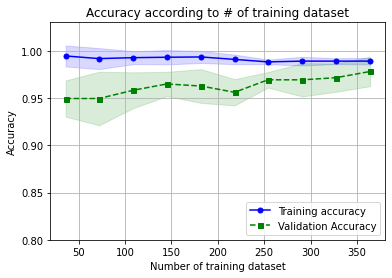

<Figure size 432x288 with 0 Axes>

In [ ]:
def draw_learning_curve(train_sizes, train_scores, valid_scores):

  train_mean= np.mean(train_scores, axis=1)
  valid_mean= np.mean(valid_scores, axis=1)
  # 학습곡선: 샘플개수에 따른 데이터 성능
  plt.plot(train_sizes, train_mean,
          color='blue', marker='o',
          markersize=5, label='Training accuracy')

  plt.plot(train_sizes, valid_mean,
          color='green', linestyle='--', marker='s', 
          markersize=5, label='Validation Accuracy')
 
  # 오차범위 시각화
  train_std = np.std(train_scores, axis=1)
  valid_std = np.std(valid_scores, axis=1)
  plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std,
                  alpha=0.15, color='blue')
  
  plt.fill_between(train_sizes, valid_mean+valid_std, valid_mean-valid_std,
                  alpha=0.15, color='green')

  plt.grid()
  plt.xlabel('Number of training dataset')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.ylim([0.8, 1.03])
  
  plt.title('Accuracy according to # of training dataset')
  plt.show()
  plt.tight_layout()
draw_learning_curve(train_sizes, train_scores, valid_scores)

* 생성한 파이프라인에 대한 학습 곡선 시각화

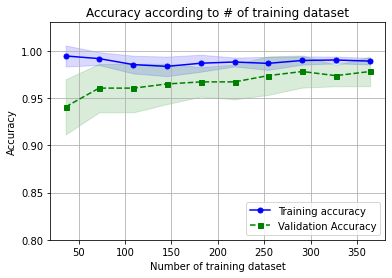

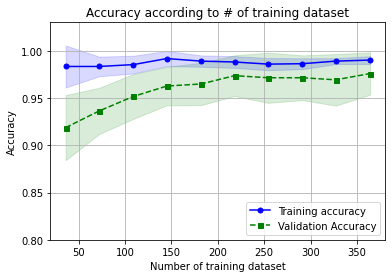

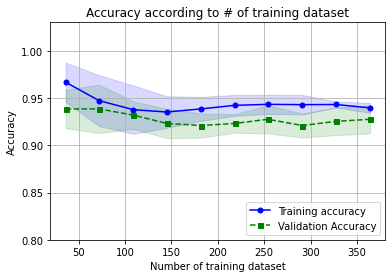

<Figure size 432x288 with 0 Axes>

In [ ]:
for pipe in ['pipe_lr', 'pipe_svc', 'pipe_pca_svc']:
  train_sizes, train_scores, valid_scores = learning_curve(estimator=eval(pipe),
                                                          X = X_train,
                                                          y = y_train,
                                                          train_sizes= np.linspace(0.1, 1, 10),
                                                          cv = 5, # 교차검증 (k=5)
                                                          shuffle=True
                                                          )
  draw_learning_curve(train_sizes, train_scores, valid_scores)

#### **검증 곡선**


* x축 : 특정 하이퍼파라미터 값
* y축 : 성능


```
sklearn.model_selection.validation_curve(estimator, 
                                        X, y, *, 
                                        param_name, 
                                        param_range,
                                        groups=None, 
                                        cv=None, 
                                        scoring=None,
                                        n_jobs=None,
                                        pre_dispatch='all', 
                                        verbose=0, 
                                        error_score=nan, 
                                        fit_params=None)[source]
```

In [ ]:
from sklearn.model_selection import validation_curve

pr = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores, valid_scores = validation_curve(estimator = pipe_pca_svc,
                                              X = X_train,
                                              y = y_train,
                                              cv = 5,
                                              param_name='svc__C',
                                              param_range=pr
                                              )
print(train_scores.shape)
print(valid_scores.shape)


(7, 5)
(7, 5)


* 시각화


In [ ]:
def draw_validation_curve(param_range, 
                          train_scores, 
                          valid_scores):
  
  train_mean= np.mean(train_scores, axis=1)
  valid_mean= np.mean(valid_scores, axis=1)
  # 검증곡선: 파라미터 값에 따른 데이터 성능
  plt.plot(param_range, train_mean,
          color='blue', marker='o',
          markersize=5, label='Training accuracy')

  plt.plot(param_range, valid_mean,
          color='green', linestyle='--', marker='s', 
          markersize=5, label='Validation Accuracy')
 
  # 오차범위 시각화
  train_std = np.std(train_scores, axis=1)
  valid_std = np.std(valid_scores, axis=1)
  plt.fill_between(param_range, train_mean+train_std, train_mean-train_std,
                  alpha=0.15, color='blue')
  
  plt.fill_between(param_range, valid_mean+valid_std, valid_mean-valid_std,
                  alpha=0.15, color='green')

  plt.grid()
  plt.xlabel('Prameter range')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.ylim([0.5, 1.03])
  plt.xscale('log') # 로그스케일
  plt.tight_layout()
  plt.title('Accuracy according to parameter range')
  plt.show()

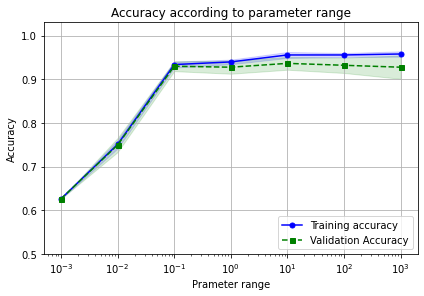

In [ ]:
draw_validation_curve(pr, train_scores, valid_scores)

### **| 하이퍼파라미터 튜닝**


    - 머신 러닝에는 두가지 파라미터가 존재
    * 학습 파라미터 
      * 훈련 데이터를 통해 모델 알고리즘이 자동으로 학습되는 데이터
      * 로지스틱 회귀의 가중치 

    * 하이퍼파라미터 
      * 로지스틱 회귀의 규제 매개변수
      * 결정트리의 깊이


#### **그리드 서치를 사용한 하이퍼파라미터 튜닝**

```
class sklearn.model_selection.GridSearchCV(estimator,
                                           param_grid,
                                           scoring=None,
                                           n_jobs=None,
                                           refit=True,
                                           cv=None, 
                                           verbose=0,
                                           pre_dispatch='2*n_jobs', 
                                           error_score=nan, 
                                           return_train_score=False)
```

* pipe_pcasvc 그리드 서치 진행하기

In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'svc__C' : [0.1, 1, 10, 100],
               'svc__gamma' : [0.001, 0.01, 0.1, 1],
               'pca__n_components' : [10, 15, 20],
               'svc__kernel': ['linear', 'rbf'] }]
gs = GridSearchCV(estimator = pipe_pca_svc, 
                  scoring = 'accuracy',
                  cv=10, # k=10 교차검증
                  param_grid = param_grid, 
                  refit = True, # 훈련후 바로 사용가능
                  return_train_score=True, # 훈련 성능 리턴
                  )
# gs는 하나의 모델, fit을 통해 최적의 하이퍼파라미터로 튜닝
gs.fit(X_train, y_train)
print(f'최적의 하이퍼파라미터 세트:{gs.best_params_}')
print(f'훈련데이터 성능: {gs.best_score_}')
print(f'테스트데이터 평가: {gs.score(X_test, y_test)}')

최적의 하이퍼파라미터 세트:{'pca__n_components': 15, 'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
훈련데이터 성능: 0.9846859903381642
테스트데이터 평가: 0.9736842105263158


In [ ]:
print(pipe_lr.score(X_test, y_test))
print(pipe_svc.score(X_test, y_test))
print(pipe_pca_svc.score(X_test, y_test))

0.9824561403508771
0.9736842105263158
0.956140350877193


In [ ]:
# 파이프라인 : z-score -> DecisionTree
# 그리드서치 : max_depth, criterion : gini / entorpy
# 최적 성능 평가
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn import set_config

set_config(display='diagram')
pipe_dt = make_pipeline(StandardScaler(),
                        DecisionTreeClassifier(random_state=1)
                        )
pipe_dt.fit(X_train, y_train)
print(pipe_dt.score(X_test, y_test))
pipe_dt

0.9298245614035088


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=1))])

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'decisiontreeclassifier__max_depth' : [2,3,4,5,6,7,8,9,10,11,12],
               'decisiontreeclassifier__criterion' : ['gini', 'entropy'],
}]
dt_gs = GridSearchCV(estimator = pipe_dt, 
                  scoring = 'accuracy',
                  cv=10, # k=10 교차검증
                  param_grid = param_grid, 
                  refit = True, # 훈련후 바로 사용가능
                  return_train_score=True, # 훈련 성능 리턴
                  )

dt_gs.fit(X_train, y_train)
print(f'최적의 하이퍼파라미터 세트:{dt_gs.best_params_}')
print(f'훈련데이터 성능: {dt_gs.best_score_}')
print(f'테스트데이터 평가: {dt_gs.score(X_test, y_test)}')

최적의 하이퍼파라미터 세트:{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 7}
훈련데이터 성능: 0.9583091787439614
테스트데이터 평가: 0.9298245614035088


## 여러가지 성능 평가 지표
---


### | 오차행렬 (confusion matrix)

<p align='center'>
<img src=https://git.io/JtsT1?=true width=400>
</p>

* 함수구현

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def draw_cm(model, X, y, title='', labels='', cmap='Blues'):
  y_pred = model.predict(X) # 예측
  cm = confusion_matrix(y, y_pred) # 혼돈 행렬 구하기
  if not labels: labels=np.arange(len(y))
  ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap=cmap) # 시각화
  if title: plt.title(title)

* 시각화

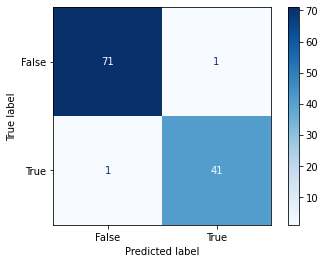

In [ ]:
draw_cm(pipe_lr, X_test, y_test, labels=['False', 'True'])

#### **예측 오차와 예측 정확도**

* 예측 오차
\begin{split}
ERR = \frac{잘못된 예측 개수}{전체 샘플 개수}
\end{split}

* 예측 정확도

\begin{split}
ACC = \frac{잘된 예측 개수}{전체 샘플 개수} = 1-ERR
\end{split}

In [ ]:
from sklearn.metrics import accuracy_score

ERR =  2/114
ACC = 112/114
print(f'예측 오차 : {ERR:.3f}')
print(f'예측 정확도 : {ACC:.3f}')

ERR = 1- accuracy_score(y_test, pipe_lr.predict(X_test))
ACC = accuracy_score(y_test, pipe_lr.predict(X_test))
print(f'예측 오차 : {ERR:.3f}')
print(f'예측 정확도 : {ACC:.3f}')

예측 오차 : 0.018
예측 정확도 : 0.982
예측 오차 : 0.018
예측 정확도 : 0.982


### **| 분류 모델의 성능 최적화**


#### **TPR (True Positive Rate), FPR (False Positive Rate)**

* TPR

\begin{split}
TPR = \frac{TP}{P} = \frac{TP}{FN+TP} = \frac{모델이 True로 예측한 샘플}{실제 True인 샘플}
\end{split}

* FPR

\begin{split}
FPR = \frac{FP}{N} = \frac{FP}{FP+TN} = \frac{모델이 True로 예측한 샘플}{실제 False인 샘플}
\end{split}

\begin{split}
\end{split}

    - TPR과 FPR은 클래스 비율이 다른 경우 유용한 성능 지표
    - 종양진단 문제에서 환자가 적절한 치료를 받을 수 있도록 악성 종양을 감지하는데 관심이 있다.(악성을 악성으로 구분, TN)
    - 불필요하게 환자에게 걱정을 끼치지 않도록 양성 샘플을 악성 샘플로 분류되는 경우(FP)를 줄이는것이 중요


In [ ]:
TPR = 41/42
FPR = 2/72
print(f'TPR : {TPR:.3f}') # 제대로 종양을 진단한 정도 = 높을 수록 좋다
# 모두 종양으로 분류해도 TPR은 1
print(f'FPR : {FPR:.3f}') # 잘못 종양이라고 진단한 정도 = 낮을 수록 좋다
# 모두 정상으로 분류해도 FPR은 0

TPR : 0.976
FPR : 0.028


#### **정밀도 (Precisison)와 재현율(Recall)**

* 정밀도

\begin{split}
PRE =  \frac{TP}{TP+FP} = \frac{실제로  True인 샘플}{모델이 True로 예측한 샘플}
\end{split}

* 재현율

\begin{split}
REC = TPR = \frac{모델이 True로 예측한 샘플}{실제 False인 샘플}
\end{split}

\begin{split}
\end{split}


    - 정밀도로 모델을 최적화 하면 생기는 일
      * 모델이 정상군을 정상이라고 판단하도록 한다.
      * 정상군을 감지하는데 효과적
      * 악성 종양을 정상으로 잘못 판단 할 수 있다. 

    - 재현율로 모델을 최적화 하면 생기는 일
      * 모델이 악성 종양을 정상이라고 판단하는 경우를 최소화 하게 된다. 
      * 악성 종양을 감지하는데 효과적
      * 정상군도 악성 종양으로 잘못 판단 할 수 있다. 



In [ ]:
from sklearn.metrics import precision_score, recall_score

REC = TPR
PRE = 41/42
print(f'REC : {REC:.3f}') 
print(f'PRE : {PRE:.3f}') 

REC = recall_score(y_test, pipe_lr.predict(X_test))
PRE = precision_score(y_test, pipe_lr.predict(X_test))
print(f'REC : {REC:.3f}')
print(f'PRE : {PRE:.3f}')

REC : 0.976
PRE : 0.976
REC : 0.976
PRE : 0.976


#### **F1-score**

\begin{split}
F1 = 2\frac{PRE \times REC}{PRE+REC}
\end{split}


In [ ]:
from sklearn.metrics import f1_score
F1 = 2*(PRE*REC)/(PRE+REC)
print(f'F1-score: {F1:.3f}')
F1 = f1_score(y_test, pipe_lr.predict(X_test))
print(f'F1-score: {F1:.3f}')

F1-score: 0.976
F1-score: 0.976


#### **AUC**

In [ ]:
from sklearn.metrics import roc_auc_score
print(f'AUC: {roc_auc_score(y_test, pipe_lr.predict(X_test)):.3f}')

AUC: 0.981


### **| 성능 평가 기준 바꿔서 검증하기**

* pipe_pcasvc 그리드 서치 진행하기, 성능은 AUC

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
auc_score = make_scorer(score_func = roc_auc_score,
                        greater_is_better = True)

param_grid = [{'svc__C' : [0.1, 1, 10, 100],
               'svc__gamma' : [0.001, 0.01, 0.1, 1],
               'pca__n_components' : [10, 15, 20],
               'svc__kernel': ['linear', 'rbf'],
}]
gs = GridSearchCV(estimator = pipe_pca_svc, 
                  scoring = auc_score,
                  cv=10, # k=10 교차검증
                  param_grid = param_grid, 
                  refit = True, # 훈련후 바로 사용가능
                  return_train_score=True, # 훈련 성능 리턴
                  )

gs.fit(X_train, y_train)
print(f'최적의 하이퍼파라미터 세트:{gs.best_params_}')
print(f'훈련데이터 성능: {gs.best_score_}')
print(f'테스트데이터 평가: {gs.score(X_test, y_test)}')


최적의 하이퍼파라미터 세트:{'pca__n_components': 15, 'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
훈련데이터 성능: 0.9806288032454361
테스트데이터 평가: 0.9692460317460317


### | ROC (Receiver Operating Characteristic)

    - 분류기의 임계값을 바꾸어 가며 계산된 fPR과 TPR 점수를 시각화한 플롯

    - ROC그래프의 대각선은 랜덤 추측인 경우이며 완벽한 분류기라면 왼쪽 위를 향하는 그래프가 그려진다.

    - ROC곡선의 아래 면적을 ROC AUC (ROC Area Under the Curve) 라 하며 성능 지표로 사용된다.



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


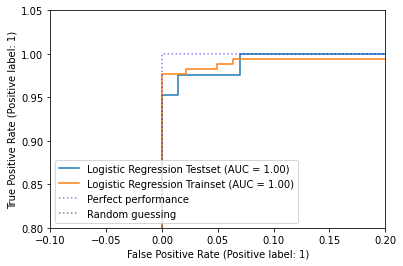

In [ ]:
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots(1)
roc_test = plot_roc_curve(pipe_lr, 
                          X_test, y_test, 
                          ax=ax, name='Logistic Regression Testset')
roc_train = plot_roc_curve(pipe_lr,
                          X_train, y_train,
                          ax=ax, name='Logistic Regression Trainset')

plt.plot([0, 0, 1], [0, 1, 1],
         linestyle=':', color='b', alpha=.5,
         label='Perfect performance')
plt.plot([0, 1], [0, 1],
         linestyle=':', color='k', alpha=.5,
         label='Random guessing')
plt.xlim([-0.1, .2])
plt.ylim([0.8, 1.05])
plt.legend()

plt.show()

### **| 다중 분류의 성능 지표**


\begin{split}
\end{split}

* 마크로 평균 

\begin{split}
PRE_{macro} = \frac{PRE_1 + ... PRE_k}{k}
\end{split}


* 마이크로 평균 

\begin{split}
PRE_{micro} = \frac{TP_1 + ... TP_k}{TP_1 + ...+ TP_k + FP_1 +  ... + FP_k}
\end{split}

\begin{split}
\end{split}


    - 마크로 평균 방식에서는 가장 빈도 높은 클래스 레이블의 성능이 영향을 미치게 된다.

    - 마이크로 평균은 각 샘플이나 예측에 동일한 가중치를 부여

    - 사이킷런에서 다중 분류 모델을 평가하면 정규화 또는 가중치가 적용된 마크로 평균이 기본적으로 적용된다.

    - 마크로 평균은 샘플 개수에 가중치가 부여되므로 레이블마다 샘플 개수가 다른 불균형한 클래스를 다룰 때 유용


In [ ]:
from sklearn.metrics import make_scorer

macro = make_scorer(score_func = precision_score, 
                    pos_label = 1, 
                    greater_is_better=True, 
                    average = 'macro') 

micro = make_scorer(score_func = precision_score, 
                    pos_label = 1, 
                    greater_is_better=True,
                    average = 'micro')

In [ ]:
param_grid = [{'svc__C' : [0.1, 1, 10, 100],
               'svc__gamma' : [0.001, 0.01, 0.1, 1],
               'svc__kernel': ['linear', 'rbf']}]
gs = GridSearchCV(estimator = pipe_svc, 
                  scoring = micro,
                  cv=10, # k=10 교차검증
                  param_grid = param_grid, 
                  refit = True, # 훈련후 바로 사용가능
                  return_train_score=True, # 훈련 성능 리턴
                  )

gs.fit(X_train, y_train)
print(f'최적의 하이퍼파라미터 세트:{gs.best_params_}')
print(f'훈련데이터 성능: {gs.best_score_}')
print(f'테스트데이터 평가: {gs.score(X_test, y_test)}')


최적의 하이퍼파라미터 세트:{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
훈련데이터 성능: 0.9846859903381642
테스트데이터 평가: 0.9736842105263158
